In [27]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv("..\medical_insurance.csv")
df.info()

x = df["bmi"].to_numpy()
y = df["charges"].to_numpy()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


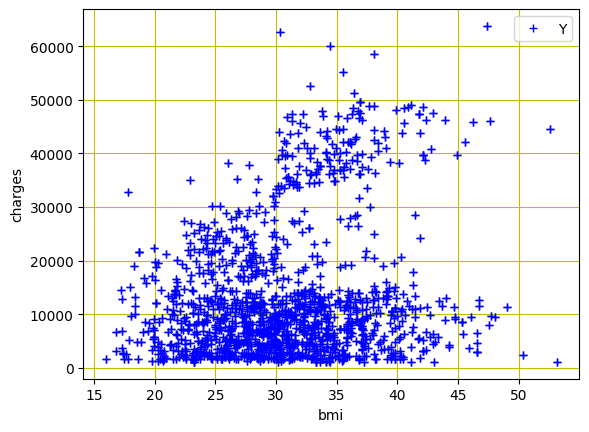

In [28]:
plt.plot(x, y, "b+", label="Y")
plt.xlabel("bmi")
plt.ylabel("charges")
plt.legend()
plt.grid(True, color="y")
plt.show()

In [29]:
import sklearn
import sklearn.model_selection
from sklearn import preprocessing

# train test split, 0.7 and 0.3
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.3, random_state=42)
print(len(x_train), ",", len(x_test), ",", len(y_train), ",", len(y_test))

x_train = x_train.astype(np.float32)
x_train = x_train.reshape(-1, 1)

x_test = x_test.astype(np.float32)
x_test = x_test.reshape(-1, 1)

y_train = y_train.astype(np.float32)
y_train = y_train.reshape(-1, 1)

y_test = y_test.astype(np.float32)
y_test = y_test.reshape(-1, 1)

print(x_train.dtype)

data_normalizer = preprocessing.MinMaxScaler()

x_train = data_normalizer.fit_transform(x_train)
x_test = data_normalizer.fit_transform(x_test)
y_train = data_normalizer.fit_transform(y_train)
y_test = data_normalizer.fit_transform(y_test)
x_train


1940 , 832 , 1940 , 832
float32


array([[0.5032768 ],
       [0.47992894],
       [0.25163838],
       ...,
       [0.2160022 ],
       [0.25163838],
       [0.86400867]], dtype=float32)

In [30]:
1940 + 832

2772

In [31]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim) -> None:
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        return out

In [32]:
input_dim = 1
output_dim = 1

model = LinearRegressionModel(input_dim=input_dim, output_dim=output_dim)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device=device)

criterion = nn.MSELoss()

learning_rate = 0.001

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [33]:
import mlflow

# set up mlflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")

mlflow.set_experiment("/testing_experiment")

# train method
def train(model, loss_fn, optimizer, loss_list, epoch, epochs):
    model.train()

    inputs = torch.from_numpy(x_train).to(device)
    labels = torch.from_numpy(y_train).to(device)

    optimizer.zero_grad()

    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss_list.append(loss)

    loss.backward()

    optimizer.step()

    #mlflow logging
    loss, current = loss.item(), epoch
    mlflow.log_metric("loss", f"{loss:3f}", step=epoch)

    print(f"loss: {loss:3f} [{current} / {epochs}]")


In [34]:
from torchinfo import summary

epochs = 1000
loss_list = []

with mlflow.start_run():
    params = {
        "epochs": epochs,
        "learning_rate": learning_rate,
        "loss_function": criterion.__class__.__name__,
        "optimizer": "SGD" 
    }

    mlflow.log_params(params)

    with open("model_summary.txt", "w") as f:
        f.write(str(summary(model)))
    mlflow.log_artifact("model_summary.txt")

    for epoch in range(epochs):
        print(f"Epoch {epoch}\n-------------------------------")
        train(
            model=model,
            loss_fn=criterion,
            optimizer=optimizer,
            loss_list=loss_list,
            epoch=epoch,
            epochs=epochs
        )

    # save model to mlflow
    mlflow.pytorch.log_model(model, "linear_model")

Epoch 0
-------------------------------
loss: 0.054342 [0 / 1000]
Epoch 1
-------------------------------
loss: 0.054326 [1 / 1000]
Epoch 2
-------------------------------
loss: 0.054294 [2 / 1000]
Epoch 3
-------------------------------
loss: 0.054250 [3 / 1000]
Epoch 4
-------------------------------
loss: 0.054194 [4 / 1000]
Epoch 5
-------------------------------
loss: 0.054128 [5 / 1000]
Epoch 6
-------------------------------
loss: 0.054054 [6 / 1000]
Epoch 7
-------------------------------
loss: 0.053973 [7 / 1000]
Epoch 8
-------------------------------
loss: 0.053885 [8 / 1000]
Epoch 9
-------------------------------
loss: 0.053793 [9 / 1000]
Epoch 10
-------------------------------
loss: 0.053698 [10 / 1000]
Epoch 11
-------------------------------
loss: 0.053599 [11 / 1000]
Epoch 12
-------------------------------
loss: 0.053498 [12 / 1000]
Epoch 13
-------------------------------
loss: 0.053396 [13 / 1000]
Epoch 14
-------------------------------
loss: 0.053293 [14 / 1000]


2024/04/19 23:00:14 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.2+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.2.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


loss: 0.042346 [987 / 1000]
Epoch 988
-------------------------------
loss: 0.042340 [988 / 1000]
Epoch 989
-------------------------------
loss: 0.042335 [989 / 1000]
Epoch 990
-------------------------------
loss: 0.042330 [990 / 1000]
Epoch 991
-------------------------------
loss: 0.042324 [991 / 1000]
Epoch 992
-------------------------------
loss: 0.042319 [992 / 1000]
Epoch 993
-------------------------------
loss: 0.042314 [993 / 1000]
Epoch 994
-------------------------------
loss: 0.042308 [994 / 1000]
Epoch 995
-------------------------------
loss: 0.042303 [995 / 1000]
Epoch 996
-------------------------------
loss: 0.042298 [996 / 1000]
Epoch 997
-------------------------------
loss: 0.042292 [997 / 1000]
Epoch 998
-------------------------------
loss: 0.042287 [998 / 1000]
Epoch 999
-------------------------------
loss: 0.042282 [999 / 1000]


2024/04/19 23:00:19 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.2+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.2.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
c:\ProgramData\anaconda3\envs\learn\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\ProgramData\anaconda3\envs\learn\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replaci

In [35]:
# get float values out of tensors
loss_list_float = [x.item() for x in loss_list]
loss_list_float

[0.05434237793087959,
 0.05432579666376114,
 0.05429442971944809,
 0.05424999073147774,
 0.05419411510229111,
 0.05412834882736206,
 0.05405411496758461,
 0.0539727546274662,
 0.05388546362519264,
 0.05379338562488556,
 0.053697507828474045,
 0.053598761558532715,
 0.05349794775247574,
 0.05339581519365311,
 0.05329299718141556,
 0.05319006368517876,
 0.0530875138938427,
 0.0529857836663723,
 0.05288523808121681,
 0.052786193788051605,
 0.05268891528248787,
 0.052593618631362915,
 0.052500493824481964,
 0.05240967869758606,
 0.052321285009384155,
 0.05223539099097252,
 0.052152056246995926,
 0.05207131430506706,
 0.05199318379163742,
 0.0519176609814167,
 0.051844727247953415,
 0.05177435651421547,
 0.05170650780200958,
 0.051641132682561874,
 0.051578179001808167,
 0.051517583429813385,
 0.05145927518606186,
 0.051403190940618515,
 0.051349248737096786,
 0.0512973852455616,
 0.05124751850962639,
 0.051199570298194885,
 0.05115346983075142,
 0.051109135150909424,
 0.05106648802757263,


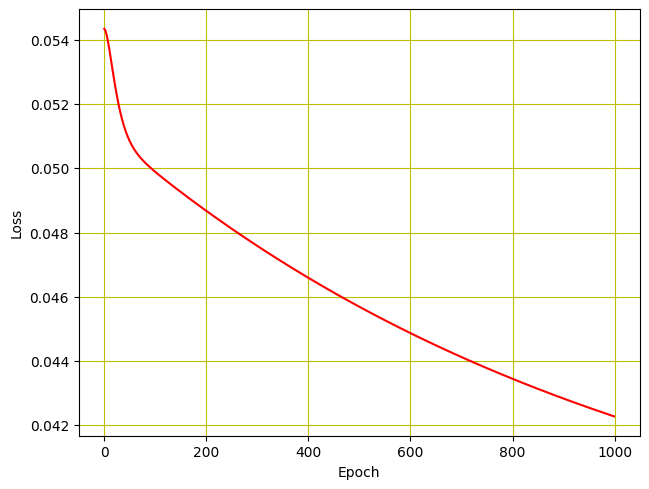

In [36]:
plt.plot(loss_list_float, "r")
plt.tight_layout()
plt.grid("True", color="y")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [37]:
model.state_dict()

OrderedDict([('linear.weight', tensor([[-0.2267]], device='cuda:0')),
             ('linear.bias', tensor([0.2933], device='cuda:0'))])

In [38]:
# save model weights, model object needed
import os

dir_name = os.path.abspath(".")
model_name = "linear1"

PATH = dir_name + "\\" + model_name

torch.save(model.state_dict(), PATH)

In [39]:
# export model in torchscript format
model_scripted = torch.jit.script(model)
model_scripted_name = PATH + ".pt"
model_scripted.save(model_scripted_name)

In [40]:
# load model for testing
# model = LinearRegressionModel(1,1)
# model.load_state_dict(torch.load(PATH, map_location="cuda:0"))
# model.to(device=device)
# model.eval()

In [41]:
len(x_test), len(y_test)

(832, 832)

In [42]:
logged_model = 'runs:/57492f733b61463ba4905c35388db863/linear_model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model

2024/04/19 23:03:39 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


mlflow.pyfunc.loaded_model:
  artifact_path: linear_model
  flavor: mlflow.pytorch
  run_id: 57492f733b61463ba4905c35388db863

In [45]:
loaded_model.predict(x_test)

array([[0.20811848],
       [0.22781882],
       [0.26804283],
       [0.14971893],
       [0.15481173],
       [0.24520145],
       [0.22534864],
       [0.13569084],
       [0.17106602],
       [0.21796866],
       [0.19607264],
       [0.18064173],
       [0.18533808],
       [0.18725932],
       [0.22894715],
       [0.21680981],
       [0.23593071],
       [0.23327759],
       [0.21315031],
       [0.20406255],
       [0.18725932],
       [0.15828826],
       [0.26721945],
       [0.16069743],
       [0.20522138],
       [0.21150352],
       [0.2840227 ],
       [0.1594471 ],
       [0.22229905],
       [0.24907444],
       [0.14910902],
       [0.25678986],
       [0.20406255],
       [0.20747808],
       [0.16789445],
       [0.16588174],
       [0.22693443],
       [0.24114549],
       [0.19790238],
       [0.24056609],
       [0.19247411],
       [0.1976889 ],
       [0.14669986],
       [0.16435695],
       [0.25331336],
       [0.10147449],
       [0.22168915],
       [0.196